# Imports

In [6]:
import shutil
from tempfile import mkdtemp
from joblib import Memory

import numpy as np
import pandas as pd

import mlflow

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator,TransformerMixin

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec, KeyedVectors

# Models used so far
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

from IPython.display import clear_output

# import lbc

import warnings
warnings.filterwarnings("ignore")


# Settigns 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)
sns.set_theme()
mlflow.set_tracking_uri("http://127.0.0.1:5000")
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

# Constants
SEED = 123

tracking URI: 'http://127.0.0.1:5000'


<br>

<br>

# Helper Functions

In [33]:



# def load_corpus(file = '../../data/2-intermediate/corpus.plk'):
#     df = pd.read_pickle(file)
#     return df.text.tolist()

def classification_report_todict(summary):
  '''
  Returns a dictionary of metrics form classification report
  '''
  cls_report_dict = {}
  cls_report_dict['0'] = {
      'precision':summary.split()[5],
      'recall':summary.split()[6],
      'f1-score':summary.split()[7]
  }
  cls_report_dict['1'] = {
      'precision':summary.split()[10],
      'recall':summary.split()[11],
      'f1-score':summary.split()[12]
  }
  cls_report_dict['accuracy'] = summary.split()[15]
  cls_report_dict['macro_avg'] = summary.split()[20]
  cls_report_dict['weighted_avg'] = summary.split()[27]
  return cls_report_dict


def log_classification_metrics_mlflow(cls_report_dict):
  mlflow.log_metric("accuracy", cls_report_dict['accuracy'])
  mlflow.log_metric("macro_avg", cls_report_dict['macro_avg'])
  mlflow.log_metric("weighted_avg", cls_report_dict['weighted_avg'])


  mlflow.log_metric("0_precision", cls_report_dict['0']['precision'])
  mlflow.log_metric("0_recall", cls_report_dict['0']['recall'])
  mlflow.log_metric("0_f1_score", cls_report_dict['0']['f1-score'])

  mlflow.log_metric("1_f1_score", cls_report_dict['1']['precision'])
  mlflow.log_metric("1_f1_score", cls_report_dict['1']['recall'])
  mlflow.log_metric("1_f1_score", cls_report_dict['1']['f1-score'])



#Helper functions
def csl_results(estimator_gs, X_test, y_test, estimator_name, mlflow_logs = True):
  
  '''Display the classification results for analysis.'''
  
  # Display best parameters from GridSearch
  print('\n\n\nModel:', estimator_name.replace('_', ' ').upper())
  print('Best params:')
  print(estimator_gs.best_params_)
  # Display metrics
  print('Best score on train:',round(estimator_gs.best_score_,3))
  # Display report
  print()
#   print('Summary on train')
#   train_summary = classification_report(y_train, estimator_gs.predict(X_train))
#   print(train_summary)
  print()
  print('Summary on test')
  summary = classification_report(y_test, estimator_gs.predict(X_test))
  print(summary)


  fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
  # Plot ROC
  plot_roc_curve(estimator = estimator_gs, X = X_test, y = y_test, ax=ax1, name = estimator_name)
  ax1.set_title('Receiver Operating Characteristic Curve', fontsize=13)

  # Plot Precision-Recall Curve
  plot_precision_recall_curve(estimator = estimator_gs, X = X_test, y = y_test, ax=ax2, name = estimator_name)
  ax2.set_title('Precision Recall Curve', fontsize=13)

  # Plot Confusion Matrix
  plot_confusion_matrix(estimator = estimator_gs, X = X_test, y_true = y_test, ax=ax3, cmap="Blues")
  ax3.set_title('Confusion Matrix', fontsize=13)
  
  # Plot settings
  fig.suptitle(estimator_name+'\n', fontsize=15)
  ax1.grid()
  ax2.grid()

  cls_report_dict = classification_report_todict(summary)
  
  if mlflow_logs:
    log_classification_metrics_mlflow(cls_report_dict)

  
      
# def run_classifier(X_train, y_train, X_test, y_test, estimator, params, metric_score, estimator_name="Classifier"):
#   # metric_score = make_scorer(sklearn.metrics.f1_score)
  
#   #Create cache file
#   cachedir = mkdtemp()
#   mem = Memory(location=cachedir, verbose=1)

#   #Create pipeline
#   steps = [('estimator', estimator)]
#   pipe = Pipeline(steps=steps, memory=mem)

#   #Grid search
#   estimator_gs = GridSearchCV(pipe, params, scoring = metric_score, cv=5, n_jobs=-1).fit(X_train, y_train)

#   #Display results
#   plot_csl_results(estimator_gs, X_test, y_test, estimator_name)

#   #Attempt to remove the temporary cachedir
#   shutil.rmtree(cachedir, ignore_errors=True)

#   return estimator_gs

<br>

<br>

# Load and Setup Data

In [3]:
# Load Data
labels = pd.read_parquet('../../data/2-intermediate/labels.parquet')[['id', 'target']]
tweets = pd.read_parquet('../../data/2-intermediate/tweets.parquet').drop_duplicates(subset=['id'])
users = pd.read_parquet('../../data/1-raw/users.parquet')[['id', 'username','name', 'location', 'followers_count', 'following_count', 'listed_count', 'tweet_count', 'verified']]
places = pd.read_parquet('../../data/1-raw/places.parquet')[['id', 'full_name', 'country', 'place_type']]

# Merges
df = tweets.copy()
df = df.merge(places, left_on='place_id', right_on='id', how='left', suffixes = (None, '_places'))
df = df.merge(users, left_on='author_id', right_on='id', how='left', suffixes = (None, '_users'))
df = df.merge(labels, on='id', how='inner', suffixes = (None, '_labels'))
df = df.drop(columns=['author_id', 'place_id', 'lang', 'is_retweet', 'verified'])
df.tokens = [list(tweet) for tweet in df.tokens.tolist()]
df.created_at = df.created_at.dt.date

# Create new features
df['nwords'] = df.tokens.apply(lambda x: len(x))
df['avg_word_lenght'] = df.tokens.apply(lambda x: np.mean([len(token) for token in x]))
df['question_mark_count'] = df.text.apply(lambda x: len([ i for i in x if i == "?"]))
df['exclamation_mark_count'] = df.text.apply(lambda x: len([ i for i in x if i == "!"]))
df['hashtag_count'] = df.text.apply(lambda x: len([ i for i in x if i == "#"]))

# df['lexicon'] = [lexdict.classify(tweet) for tweet in [' '.join(token) for token in df.tokens.tolist()]]

print('\ndf shape:',df.shape)
display(df.head(3))



df shape: (2271, 26)


,id,created_at,text,subject,created_at_date,created_at_time,emoji,tokens,id_places,full_name,country,place_type,id_users,username,name,location,followers_count,following_count,listed_count,tweet_count,target,nwords,avg_word_lenght,question_mark_count,exclamation_mark_count,hashtag_count
0,1542153389949198339,2022-06-29,"Que vergonha, só poderia ser um escolhido do Bolsonaro.#ApuraçãoAssedioPG #ForaPedroGuimarães #AfastamentoJá https://t.co/1CAyiI81Lx",bolsonaro,2022-06-29,14:29:54,None,"[vergonha, poder, escolher, bolsonaro, apuraçãoassediopg, forapedroguimarães, afastamento]",<NA>,<NA>,<NA>,<NA>,865558287307100160,pamim2005,Simoni🚩🚩🚩🚩,"Florianópolis, Brazil",465,769,0,2503,0,7,10.857143,0,0,3
1,1542153354813575173,2022-06-29,"A proliferação de falsos profetas, chantagistas, achacadores e assaltantes dos cofres públicos no governo Bolsonaro é enorme safadeza e tem que ser investigada a fundo 🤔",bolsonaro,2022-06-29,14:29:46,🤔,"[proliferação, falso, profeta, chantagista, achacador, assaltante, cofre, público, governo, bolsonaro, enorme, safadeza, investigar, fundo, estranho]",<NA>,<NA>,<NA>,<NA>,71862789,Helio__Chaves,Hélio Chaves,Brasil,306,515,9,57085,0,15,7.933333,0,0,0
2,1542153308739182592,2022-06-29,"@UOLNoticias @madeleinelacsko Vcs da UOLixo são mto RIDÍCULOS. Sem noção, militantes políticos se passando por jornalistas. Que isso??? E daí que Piquet é bolsonarista. Se ele fosse lulista, puxasse saco do chefe de vcs a reportagem seria diferente? Piquet é Piquet com ou sem Bolsonaro. Chega seus RIDÍCULOS",bolsonaro,2022-06-29,14:29:35,None,"[monotipia, prolixo, ridículos, noção, militante, político, passar, jornalista, piquet, rastreava, jurista, puxar, saco, chefe, reportagem, diferente, piquet, piquet, bolsonaro, chega, ridículos]",<NA>,<NA>,<NA>,<NA>,965716058022825987,scalioni_abreu,Cláudia Eliane Scalioni Abreu,<NA>,0,12,0,243,1,21,7.285714,4,0,0


## BOW - CountVectorizer




Model: NAIVE BAYESMULTINOMIALNB'>
Best params:
{'estimator__alpha': 0.9, 'vectorizer__ngram_range': (1, 3)}
Best score on train: 0.682

Summary on train
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       960
           1       0.99      0.99      0.99       970

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930


Summary on test
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       172
           1       0.69      0.70      0.70       169

    accuracy                           0.70       341
   macro avg       0.70      0.70      0.70       341
weighted avg       0.70      0.70      0.70       341




Model: SVM CLASSES
Best params:
{'estimator__C': 0.5, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'vectorizer__ngram_range': (1, 3)}
Best score on tra

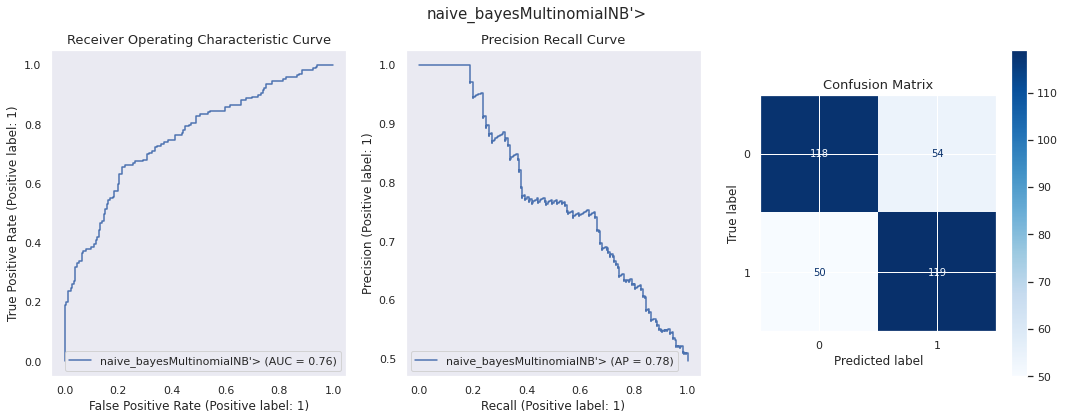

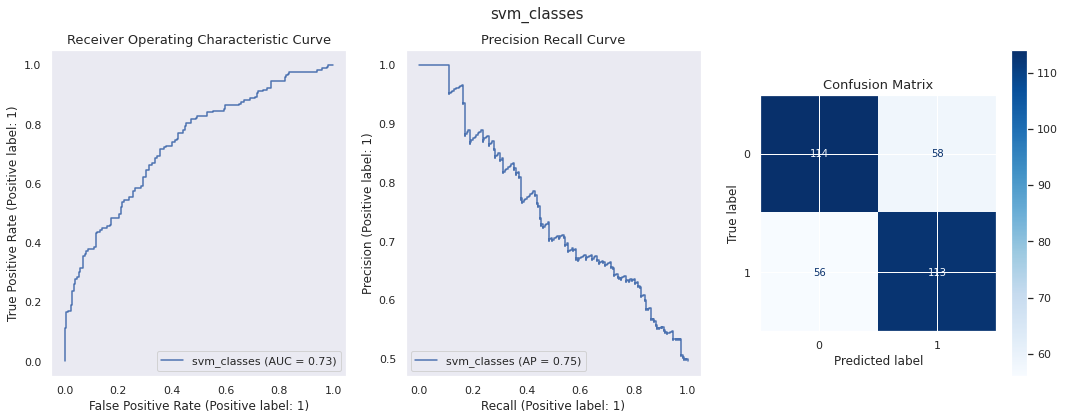

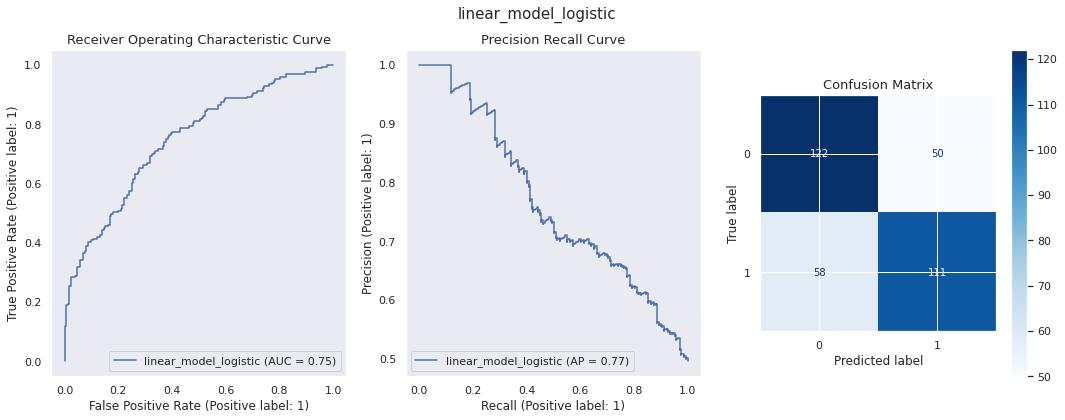

In [29]:

mlflow.set_experiment("bow")


# Setup Data
X_train, X_test, y_train, y_test = train_test_split(df.tokens, df.target, test_size=0.15, random_state=SEED)

X_train = [' '.join(tweet) for tweet in X_train.values]
X_test = [' '.join(tweet) for tweet in X_test.values]
y_train = y_train.values
y_test = y_test.values

metric_score = 'accuracy'


models_dict = {
        MultinomialNB() : {
            'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
            # 'vectorizer__max_df' : [0,5,10],
            # 'vectorizer__min_df' :  [0,5,10],
            'estimator__alpha' : [0.4,0.5,0.6,0.7,0.8,0.9,1]
        },
        
        LinearSVC(random_state=SEED) : {
            'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
            'estimator__loss': ['hinge', 'squared_hinge'], 
            'estimator__penalty': ['l1', 'l2'],
            'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        },
        LogisticRegression(n_jobs = -1, random_state=SEED) : {
            'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
            'estimator__penalty': ['l1', 'l2', 'elasticnet'],
            'estimator__dual': [True],
            'estimator__solver' : ['liblinear'],
            'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        },
        KNeighborsClassifier(n_jobs = -1) : {
            'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
            'estimator__n_neighbors': [2,3,5,8,13,21,34],
            'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        },
         RandomForestClassifier(random_state=SEED, n_jobs=-1) : {
          'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
          'estimator__min_samples_split': [2,3,5,8,13,21],
          'estimator__min_samples_leaf': [2,3,5,8,13,21],
          'estimator__max_depth': [15,30,60,120,240, None],
          'estimator__n_estimators' : np.arange(50,1200,200)
        },
         XGBClassifier(random_state=SEED, n_jobs=-1) : {
          'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
          'estimator__max_depth': [2,3,5,8],
          'estimator__eta': [0.05,0.1,0.3,0.5],
          'estimator__max_depth': [15,30,60,120,240, None],
          'estimator__n_estimators' : np.arange(50,1200,200)
        },

}



# Setup pipeline steps
vec = CountVectorizer()

for estimator,params in models_dict.items():
    
    # Create pipeline
    steps = [('vectorizer', vec),('estimator', estimator)]
    pipe = Pipeline(steps=steps)

    estimator_name = str(estimator.__class__).split('.')[1] + str(estimator.__class__).split('.')[2]
    with mlflow.start_run():
        mlflow.set_tag('model', estimator_name)
        
        # Run Grid Search
        gs = GridSearchCV(pipe, params, scoring = metric_score, cv=5).fit(X_train, y_train)

        # Evaluation
        csl_results(gs, X_test, y_test, estimator_name)

---

<br>

<br>

# TF-IDF




Model: NAIVE BAYESMULTINOMIALNB'>
Best params:
{'estimator__alpha': 0.8, 'vectorizer__ngram_range': (1, 3)}
Best score on train: 0.678


Summary on test
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       172
           1       0.69      0.72      0.70       169

    accuracy                           0.70       341
   macro avg       0.70      0.70      0.70       341
weighted avg       0.70      0.70      0.70       341




Model: SVM CLASSES
Best params:
{'estimator__C': 0.1, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'vectorizer__ngram_range': (1, 2)}
Best score on train: 0.675


Summary on test
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       172
           1       0.72      0.64      0.68       169

    accuracy                           0.70       341
   macro avg       0.70      0.70      0.70       341
weighted avg       0.70      0.70      0.70 

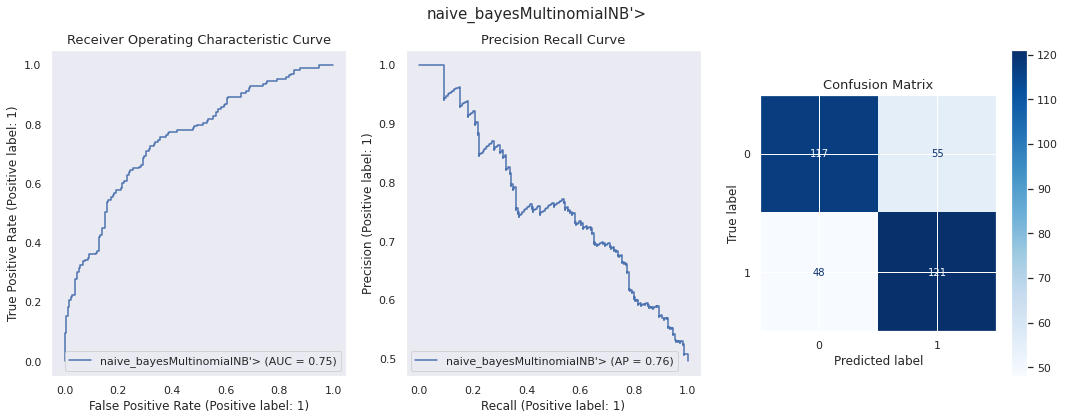

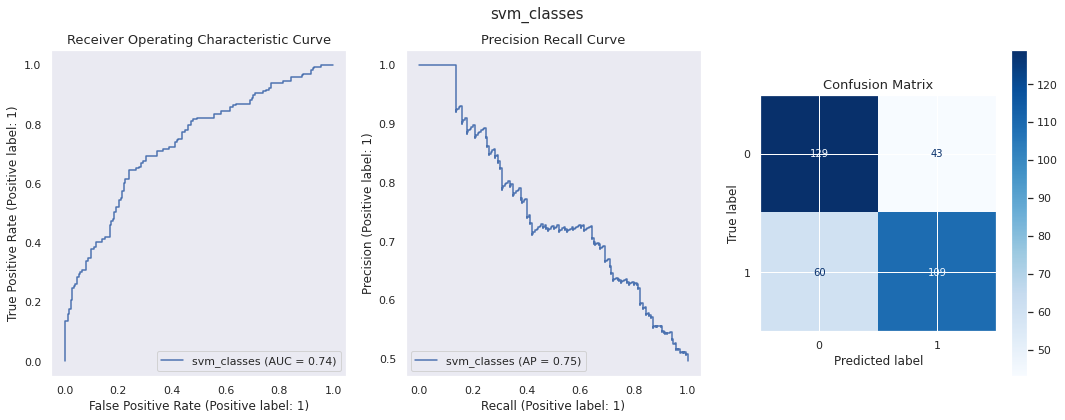

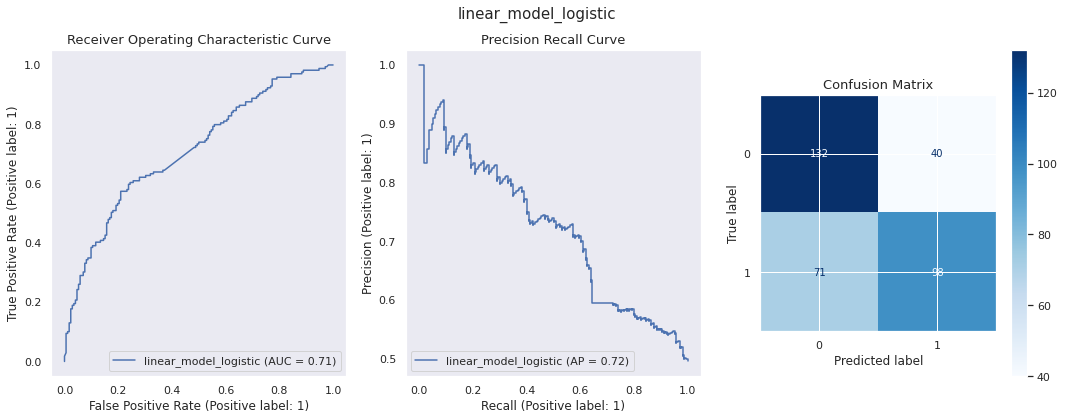

In [34]:

mlflow.set_experiment("Tf-Idf")


# Setup Data
X_train, X_test, y_train, y_test = train_test_split(df.tokens, df.target, test_size=0.15, random_state=SEED)

X_train = [' '.join(tweet) for tweet in X_train.values]
X_test = [' '.join(tweet) for tweet in X_test.values]
y_train = y_train.values
y_test = y_test.values

metric_score = 'accuracy'



models_dict = {
        MultinomialNB() : {
            'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
            'estimator__alpha' : [0.4,0.5,0.6,0.7,0.8,0.9,1]
        },
        
        LinearSVC(random_state=SEED) : {
            'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
            'estimator__loss': ['hinge', 'squared_hinge'], 
            'estimator__penalty': ['l1', 'l2'],
            'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        },
        LogisticRegression(n_jobs = -1, random_state=SEED) : {
            'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
            'estimator__penalty': ['l1', 'l2', 'elasticnet'],
            'estimator__dual': [True],
            'estimator__solver' : ['liblinear'],
            'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        },
        # KNeighborsClassifier(n_jobs = -1) : {
        #     'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
        #     'estimator__n_neighbors': [2,3,5,8,13,21,34],
        #     'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        # },
        #  RandomForestClassifier(random_state=SEED, n_jobs=-1) : {
        #   'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
        #   'estimator__min_samples_split': [2,3,5,8,13,21],
        #   'estimator__min_samples_leaf': [2,3,5,8,13,21],
        #   'estimator__max_depth': [15,30,60,120,240, None],
        #   'estimator__n_estimators' : np.arange(50,1200,100)
        # },
        #  XGBClassifier(random_state=SEED, n_jobs=-1) : {
        #   'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
        #   'estimator__max_depth': [2,3,5,8],
        #   'estimator__eta': [0.05,0.1,0.3,0.5],
        #   'estimator__max_depth': [15,30,60,120,240, None],
        #   'estimator__n_estimators' : np.arange(50,1200,100)
        # },


}


# Setup pipeline steps
vec = TfidfVectorizer()

for estimator,params in models_dict.items():
    
    # Create pipeline
    steps = [('vectorizer', vec),('estimator', estimator)]
    pipe = Pipeline(steps=steps)

    estimator_name = str(estimator.__class__).split('.')[1] + str(estimator.__class__).split('.')[2]
    with mlflow.start_run():
        mlflow.set_tag('model', estimator_name)
        
        # Run Grid Search
        gs = GridSearchCV(pipe, params, scoring = metric_score, cv=5).fit(X_train, y_train)

        # Evaluation
        csl_results(gs, X_test, y_test, estimator_name)

<br>

<br>


# Word2Vec

Using word embeddings trained by NILC - Núcleo Interinstitucional de Linguística Computacional

http://www.nilc.icmc.usp.br/embeddings

## SkipGram Size = 300


### Helper Functions

In [38]:

class Word2VecTransformer(BaseEstimator,TransformerMixin):
    def __init__(self, model):
        self.model = model

    def vectorize(self, corpus):
        """
        Generate vectors for list of documents.
        """
        features = []

        for tweet in corpus:
            zero_vector = np.zeros(self.model.vector_size)
            vectors = []
            for token in tweet:
                if token in self.model.wv:
                    try:
                        vectors.append(self.model.wv[token])
                    except KeyError:
                        continue
            if vectors:
                vectors = np.asarray(vectors)
                avg_vec = vectors.mean(axis=0)
                features.append(avg_vec)
            else:
                features.append(zero_vector)
        return features

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X = self.vectorize(X)
        return X



class FineTunnedW2V:
    '''
    Check fine-tunning by comparing most similar words of each model.
    '''

    def __init__(self, pretrained_model, finetunned_model):
        self.pretrained_model = pretrained_model
        self.finetunned_model = finetunned_model


    def check(self, word):
        '''
        Check fine-tunning by comparing most similar words of each model.
        '''
        print('Pre trained model:')
        try:
            for i in self.pretrained_model.wv.most_similar(word):
                print('\t',i)
        except:
            print(f'\t Word {word} was not found in the vocabulary.')

        print('\n\nFine tunned model:')
        try:
            for i in self.finetunned_model.wv.most_similar(word):
                print('\t',i)
        except:
            print(f'\t Word {word} was not found in the vocabulary.')

### Model Fine-Tunning

In [46]:
def tolist(corpus):
    return [list(i) for i in corpus]

full_corpus = pd.read_parquet('../../data/2-intermediate/tweets.parquet')
full_corpus = tolist(full_corpus.tokens.tolist())


model_original = KeyedVectors.load_word2vec_format("../../data/4-models/skip_s300.txt")

model = Word2Vec(size=300, min_count=1)
model.build_vocab(full_corpus)
model.intersect_word2vec_format("../../data/4-models/skip_s300.txt", lockf=1)
total_examples = model.corpus_count
model.train(full_corpus, total_examples=total_examples, epochs=15)


(3190398, 3598440)

In [47]:
model_checker = FineTunnedW2V(model_original, model)
model_checker.check('lula')

Pre trained model:
	 ('ex-presidente', 0.7038049697875977)
	 ('inрcio', 0.6858668327331543)
	 ('inácio', 0.6723729372024536)
	 ('petista', 0.6703453063964844)
	 ('lula.o', 0.6409705877304077)
	 ('inăącio', 0.6089321374893188)
	 ('depoimento.o', 0.607970654964447)
	 ('ex\xad-presidente', 0.6042797565460205)
	 ('inαcio', 0.6017224788665771)
	 ('fhc', 0.578185498714447)


Fine tunned model:
	 ('2018', 0.4012700319290161)
	 ('ulular', 0.38645827770233154)
	 ('tirar', 0.3632909655570984)
	 ('blogdonoblat', 0.36328059434890747)
	 ('novamente', 0.36132264137268066)
	 ('petista', 0.3559802174568176)
	 ('petistas', 0.3523947596549988)
	 ('haddad', 0.3452129364013672)
	 ('inácio', 0.3446679711341858)
	 ('centraleleicoes', 0.3441014289855957)


In [48]:
model_checker.check('bolsonaro')

Pre trained model:
	 ('psc-rj', 0.7009210586547852)
	 ('pp-rj', 0.62958824634552)
	 ('psc/rj', 0.5954899787902832)
	 ('wyllys', 0.5669391751289368)
	 ('psol-rj', 0.552598774433136)
	 ('meneguelli', 0.5525249242782593)
	 ('psc-sp', 0.5260335206985474)
	 ('deputado', 0.5177482962608337)
	 ('pt-sp', 0.5062705874443054)
	 ('marun', 0.49914053082466125)


Fine tunned model:
	 ('exbolsonaro', 0.3955676555633545)
	 ('atual', 0.3654123544692993)
	 ('jair', 0.36427628993988037)
	 ('messias', 0.34555771946907043)
	 ('bozó', 0.3338508605957031)
	 ('responsar', 0.33080917596817017)
	 ('oposição', 0.32640308141708374)
	 ('salmourado', 0.3189390003681183)
	 ('certo', 0.3182890713214874)
	 ('petista', 0.3069875240325928)





Model: SVM CLASSES
Best params:
{'estimator__C': 3, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2'}
Best score on train: 0.554


Summary on test
              precision    recall  f1-score   support

           0       0.54      0.87      0.67       172
           1       0.66      0.25      0.36       169

    accuracy                           0.56       341
   macro avg       0.60      0.56      0.51       341
weighted avg       0.60      0.56      0.52       341




Model: LINEAR MODEL LOGISTIC
Best params:
{'estimator__C': 0.5, 'estimator__dual': True, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
Best score on train: 0.555


Summary on test
              precision    recall  f1-score   support

           0       0.54      0.88      0.67       172
           1       0.67      0.25      0.36       169

    accuracy                           0.57       341
   macro avg       0.60      0.56      0.52       341
weighted avg       0.60      0.57     

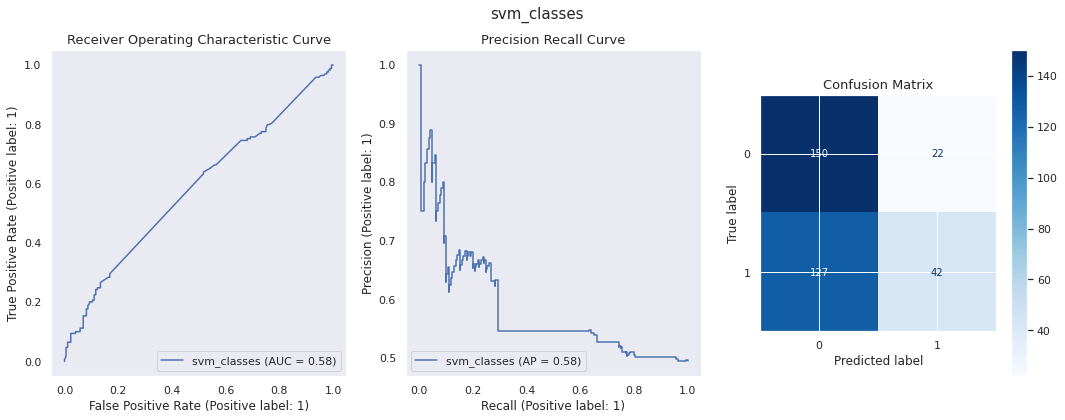

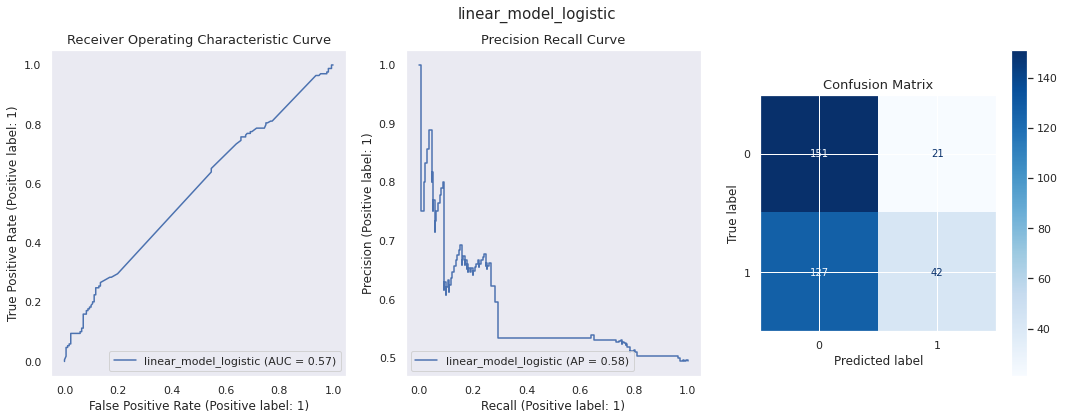

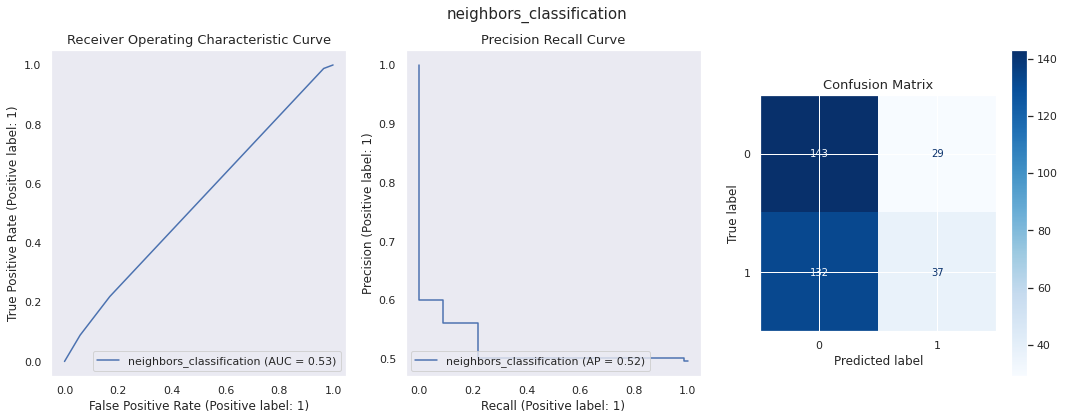

In [49]:

mlflow.set_experiment("word2vec")


# Setup Data
X_train, X_test, y_train, y_test = train_test_split(df.tokens, df.target, test_size=0.15, random_state=SEED)

X_train = [' '.join(tweet) for tweet in X_train.values]
X_test = [' '.join(tweet) for tweet in X_test.values]
y_train = y_train.values
y_test = y_test.values

metric_score = 'accuracy'



models_dict = {
        # MultinomialNB() : {
        #     'estimator__alpha' : [0.4,0.5,0.6,0.7,0.8,0.9,1]
        # },
        
        LinearSVC(random_state=SEED) : {
            'estimator__loss': ['hinge', 'squared_hinge'], 
            'estimator__penalty': ['l1', 'l2'],
            'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        },
        LogisticRegression(n_jobs = -1, random_state=SEED) : {
            'estimator__penalty': ['l1', 'l2', 'elasticnet'],
            'estimator__dual': [True],
            'estimator__solver' : ['liblinear'],
            'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        },
        KNeighborsClassifier(n_jobs = -1) : {
            'estimator__n_neighbors': [2,3,5,8,13,21,34],
            'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        },
        #  RandomForestClassifier(random_state=SEED, n_jobs=-1) : {
        #   'estimator__min_samples_split': [2,3,5,8,13,21],
        #   'estimator__min_samples_leaf': [2,3,5,8,13,21],
        #   'estimator__max_depth': [15,30,60,120,240, None],
        #   'estimator__n_estimators' : np.arange(50,1200,100)
        # },
        #  XGBClassifier(random_state=SEED, n_jobs=-1) : {
        #   'estimator__max_depth': [2,3,5,8],
        #   'estimator__eta': [0.05,0.1,0.3,0.5],
        #   'estimator__max_depth': [15,30,60,120,240, None],
        #   'estimator__n_estimators' : np.arange(50,1200,100)
        # },
        #  XGBClassifier(random_state=SEED, n_jobs=-1) : {
        #   'estimator__eta': [0.5],
        #   'estimator__max_depth': [None],
        #   'estimator__n_estimators' : [500]
        # },


}

# vec = Word2VecTransformer(model)

# for estimator,params in models_dict.items():
    
#     estimator_name = str(estimator.__class__).split('.')[1]
    
#     with mlflow.start_run():
#         mlflow.set_tag('model', estimator_name)
#         mlflow.sklearn.autolog()
#         # Create pipeline
#         steps = [('vectorizer', vec),('estimator', estimator)]
#         pipe = Pipeline(steps=steps)

#         # Run Grid Search
#         gs = GridSearchCV(pipe, params, scoring = metric_score, cv=5).fit(X_train, y_train)

#         # Evaluation
#         csl_results(gs, X_test, y_test, estimator_name)



# Setup pipeline steps
vec = Word2VecTransformer(model)

for estimator,params in models_dict.items():
    
    # Create pipeline
    steps = [('vectorizer', vec),('estimator', estimator)]
    pipe = Pipeline(steps=steps)

    estimator_name = str(estimator.__class__).split('.')[1] + str(estimator.__class__).split('.')[2]
    with mlflow.start_run():
        mlflow.set_tag('model', estimator_name)
        
        # Run Grid Search
        gs = GridSearchCV(pipe, params, scoring = metric_score, cv=5).fit(X_train, y_train)

        # Evaluation
        csl_results(gs, X_test, y_test, estimator_name)

---

<br>

# Features based on MetaData 

Testing predictive power of metadata features.

Subject: cadidate Lula or Bolsonaro

Followers count: Number of accounts following the account responsible for the tweet

Following count: Number of accounts the account responsible for the tweet is following 

Listed count: Unkown

Tweets count: Total number of tweets of the account responsible for the tweet 

nwords: Total tweet's number of words

avg_word_lenght: Average length tweet's of words

question_mark_count: Number of question marks

exclamation_mark_count: Number of exclamation marks

hashtag_count: Number of hashtags

In [178]:
df_ = df[['subject','followers_count', 'following_count', 'listed_count', 'tweet_count', 'nwords', 'avg_word_lenght', 'question_mark_count', 'exclamation_mark_count', 'hashtag_count', 'lexicon','target']]
df_['subject'] = np.where(df_['subject'] == 'bolsonaro', 1, 0)
df_

,subject,followers_count,following_count,listed_count,tweet_count,nwords,avg_word_lenght,question_mark_count,exclamation_mark_count,hashtag_count,lexicon,target
0,1,465,769,0,2503,7,10.857143,0,0,3,1.0,0
1,1,306,515,9,57085,15,7.933333,0,0,0,0.0,0
2,1,0,12,0,243,21,7.285714,4,0,0,-1.0,1
3,1,11,102,0,367,14,6.357143,0,0,0,1.0,1
4,1,8550,8572,51,779246,9,6.666667,0,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2266,0,2793,163,2,1079,5,6.400000,0,0,0,0.0,1
2267,0,602,1377,1,6122,31,5.580645,0,0,0,3.0,1
2268,0,0,35,0,271,24,6.291667,1,0,0,-2.0,1
2269,0,39,274,0,1194,5,8.000000,0,0,0,1.0,1


2022/08/08 17:02:46 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
               ...`
2022/08/08 17:02:57 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
2022/08/08 17:02:57 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('scaler', StandardScaler()), ('estimator', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              e...`
2022/08/08 17:02:57 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_byleve




Model: SKLEARN
Best params:
{'estimator__eta': 0.6, 'estimator__max_depth': None, 'estimator__n_estimators': 1200}
Best score on train (f1-macro): 0.555

Summary on train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       970

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930


Summary on test
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       172
           1       0.60      0.57      0.58       169

    accuracy                           0.60       341
   macro avg       0.60      0.60      0.60       341
weighted avg       0.60      0.60      0.60       341



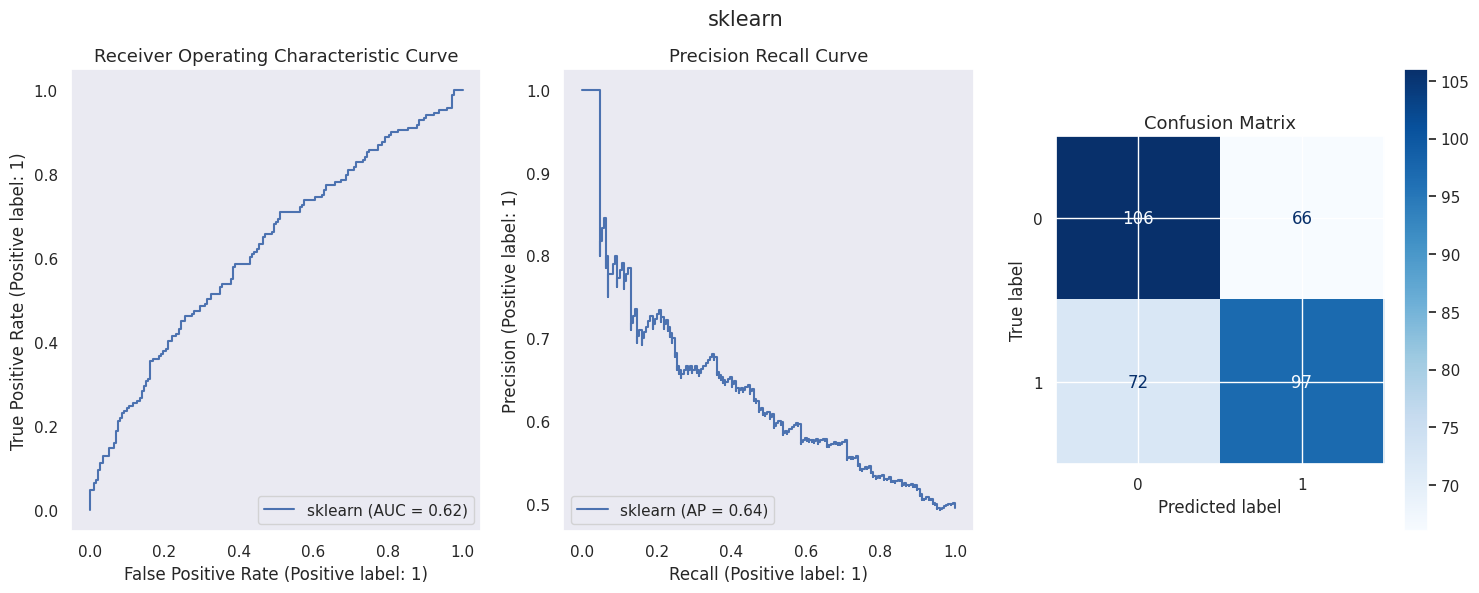

In [180]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


mlflow.set_experiment("fetures_only")


# Setup Data
X_train, X_test, y_train, y_test = train_test_split(df_.drop(columns = ['target']), df_.target, test_size=0.15, random_state=SEED)

# X_train = [' '.join(tweet) for tweet in X_train.values]
# X_test = [' '.join(tweet) for tweet in X_test.values]
# y_train = y_train.values
# y_test = y_test.values

metric_score = 'accuracy'



models_dict = {
        # MultinomialNB() : {
        #     'estimator__alpha' : [0.4,0.5,0.6,0.7,0.8,0.9,1]
        # },
        
        # LinearSVC(random_state=SEED) : {
        #     'estimator__loss': ['hinge', 'squared_hinge'], 
        #     'estimator__penalty': ['l1', 'l2'],
        #     'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        # },
        # LogisticRegression(n_jobs = -1, random_state=SEED) : {
        #     'estimator__penalty': ['l1', 'l2', 'elasticnet'],
        #     'estimator__dual': [True],
        #     'estimator__solver' : ['liblinear'],
        #     'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        # },
        # DecisionTreeClassifier(random_state=SEED) : {
        #     'estimator__min_samples_split': [2,3,5,8,13,21,34],
        #     'estimator__max_features': ['autp', 'log2'],
        # },
        # KNeighborsClassifier(n_jobs = -1) : {
        #     'estimator__n_neighbors': [2,3,5,8,13,21,34],
        #     'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        # },
        #  RandomForestClassifier(random_state=SEED, n_jobs=-1) : {
        #   'estimator__min_samples_split': [2,3,5,8,13,21],
        #   'estimator__min_samples_leaf': [2,3,5,8,13,21],
        #   'estimator__max_depth': [15,30,60,120,240, None],
        #   'estimator__n_estimators' : np.arange(50,1200,100)
        # },
        #  XGBClassifier(random_state=SEED, n_jobs=-1) : {
        #   'estimator__max_depth': [2,3,5,8],
        #   'estimator__eta': [0.05,0.1,0.3,0.5],
        #   'estimator__max_depth': [15,30,60,120,240, None],
        #   'estimator__n_estimators' : np.arange(50,1200,100)
        # },
         XGBClassifier(random_state=SEED, n_jobs=-1) : {
          'estimator__eta': [0.6],
          'estimator__max_depth': [None],
          'estimator__n_estimators' : [1200],
          # 'estimator__max_leaves' : [2,3,4,5]

        },


}

scaler = StandardScaler()

for estimator,params in models_dict.items():
    
    estimator_name = str(estimator.__class__).split('.')[1]
    
    with mlflow.start_run():
        mlflow.set_tag('model', estimator_name)
        mlflow.sklearn.autolog()
        # Create pipeline
        steps = [('scaler', scaler),('estimator', estimator)]
        pipe = Pipeline(steps=steps)

        # Run Grid Search
        gs = GridSearchCV(pipe, params, scoring = metric_score, cv=5).fit(X_train, y_train)

        # Evaluation
        csl_results(gs, X_test, y_test, estimator_name)

In [183]:
classifier =  gs.best_estimator_.steps[1][1]

In [ ]:
# import shap
# explainer = shap.TreeExplainer(classifier)
# shap.summary_plot(shap_values, X)

# shap.summary_plot(shap_values, X)


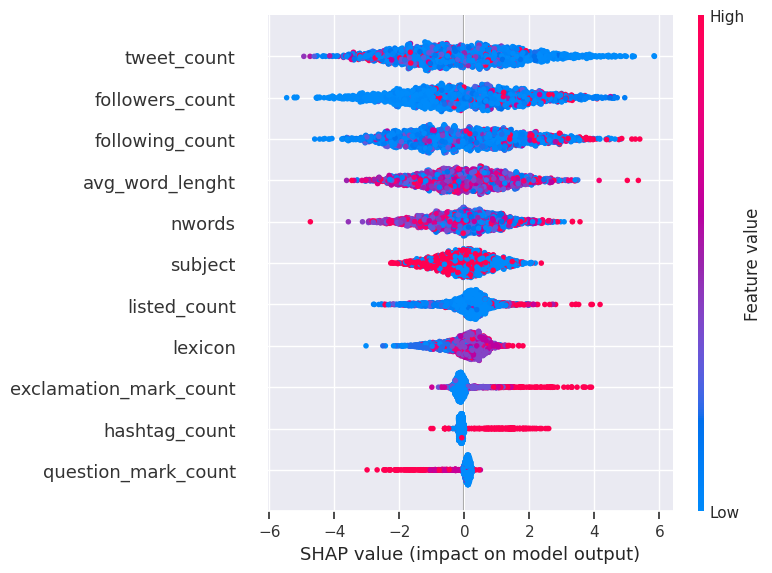

In [184]:
import shap
classifier =  gs.best_estimator_.steps[1][1]
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(scaler.fit_transform(X_train))
shap.summary_plot(shap_values, X_train)


# BOW + Meta Data

In [187]:
from sklearn.compose import ColumnTransformer

def setup_metadata(X_raw):
    X_meta = X_raw[['subject','followers_count', 'following_count', 'listed_count', 'tweet_count', 'nwords', 'avg_word_lenght', 'question_mark_count', 'exclamation_mark_count', 'hashtag_count', 'lexicon']].copy().reset_index(drop=True)
    X_meta.subject = np.where(X_meta.subject=='lula', 1, 0)
    return X_meta

def setup_tweets(X_raw):
    X_vec = [' '.join(tweet) for tweet in X_raw.tokens.values]
    return X_vec

def setup_data(X_train_raw, X_test_raw, y_train_raw, y_test_raw):
    X_train_meta = setup_metadata(X_train_raw)
    X_test_meta = setup_metadata(X_test_raw)

    X_train_vec = setup_tweets(X_train_raw)
    X_test_vec = setup_tweets(X_test_raw)

    X_train = pd.concat([X_train_meta, pd.Series(X_train_vec).rename('tokens')],axis=1)
    X_test = pd.concat([X_test_meta, pd.Series(X_test_vec).rename('tokens')],axis=1)

    y_train = y_train_raw.values
    y_test = y_test_raw.values

    return X_train, X_test, y_train, y_test




X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(df.drop(columns=['target']), df.target, test_size=0.20, random_state=SEED)

X_train, X_test, y_train, y_test  = setup_data(X_train_raw, X_test_raw, y_train_raw, y_test_raw )



2022/08/08 17:28:48 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('union',
                 ColumnTransformer(transformers=[('vectorizer',
                                                  CountVectorizer(), 'tokens'),
                                                 ('scaler',
                 ...`
2022/08/08 17:29:54 INFO mlflow.sklearn.utils: Logging the 5 best runs, 11 runs will be omitted.
2022/08/08 17:29:54 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('union', ColumnTransformer(transformers=[('vectorizer', CountVectorizer(), 'tokens'),
                                ('scaler', MinMaxScaler(clip=True),
                                 slice(0, 10, None))])), ('estimator', RandomForestClassifi...`
2022/08/08 17:29:54 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('union', ColumnTransformer(transformers=[('vectorizer', CountVectorizer(), 'tokens'),
       




Model: ENSEMBLE FOREST
Best params:
{'estimator__max_depth': None, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 8, 'estimator__n_estimators': 200, 'union__vectorizer__ngram_range': (1, 3)}
Best score on train: 0.672

Summary on train
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       899
           1       0.92      0.86      0.89       917

    accuracy                           0.89      1816
   macro avg       0.89      0.89      0.89      1816
weighted avg       0.89      0.89      0.89      1816


Summary on test
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       233
           1       0.69      0.61      0.65       222

    accuracy                           0.68       455
   macro avg       0.68      0.68      0.67       455
weighted avg       0.68      0.68      0.68       455



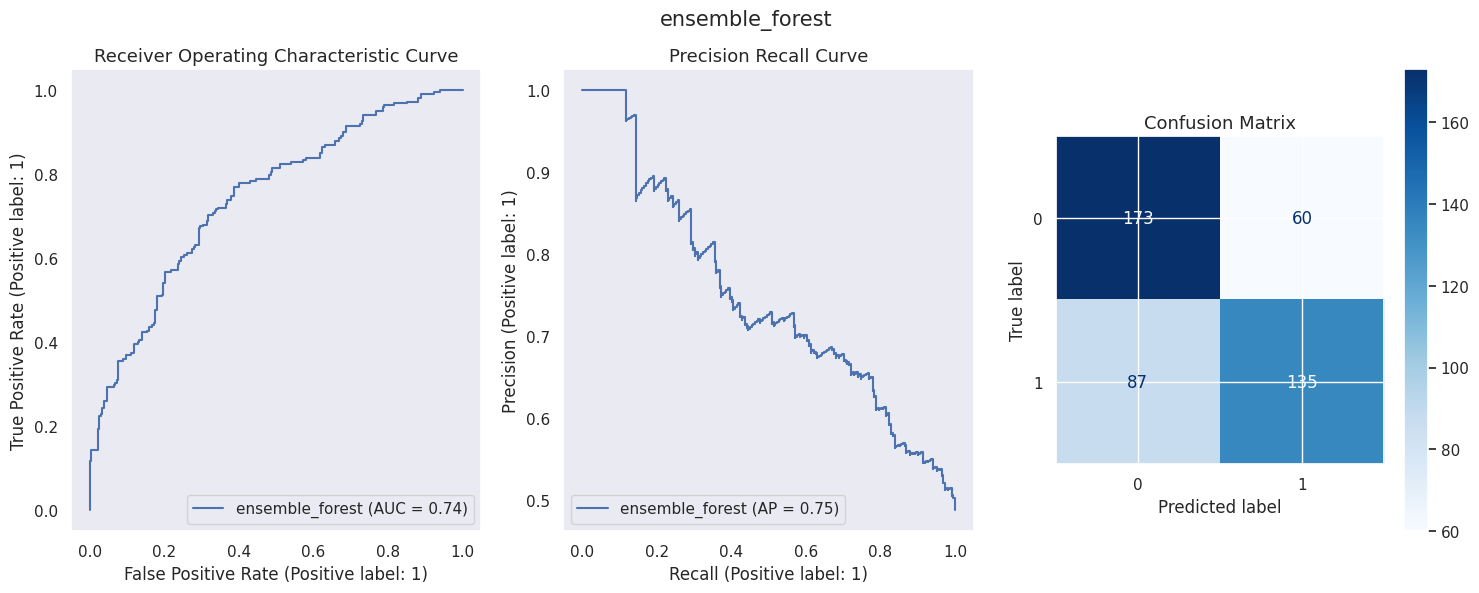

In [189]:
mlflow.set_experiment("bow_meta_data")

metric_score = 'accuracy'
# metric_score = 'f1_macro'

models_dict = {
        # MultinomialNB() : {
        #     'union__vectorizer__ngram_range' : [(1,3)],
        #     'estimator__alpha' : [0.4,0.5,0.6,0.7,0.8,0.9,1]
        # },
        
        # LinearSVC(random_state=SEED) : {
        #     'union__vectorizer__ngram_range' : [(1,3)],
        #     'estimator__loss': ['hinge', 'squared_hinge'], 
        #     'estimator__penalty': ['l1', 'l2'],
        #     'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        # },
        # LogisticRegression(n_jobs = -1, random_state=SEED) : {
        #     'union__vectorizer__ngram_range' : [(1,3)],
        #     'estimator__penalty': ['l1', 'l2', 'elasticnet'],
        #     'estimator__dual': [True],
        #     'estimator__solver' : ['liblinear'],
        #     'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        # },
        # # DecisionTreeClassifier(random_state=SEED) : {
        # #     'union__vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
        # #     'estimator__min_samples_split': [2,3,5,8,13,21,34],
        # #     'estimator__max_features': ['autp', 'log2'],
        # # },
        # KNeighborsClassifier(n_jobs = -1) : {
        #     'union__vectorizer__ngram_range' : [(1,3)],
        #     'estimator__n_neighbors': [2,3,5,8,13,21,34],
        #     'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        # },
         RandomForestClassifier(random_state=SEED, n_jobs=-1) : {
          'union__vectorizer__ngram_range' : [(1,3)],
          'estimator__min_samples_split': [2,3,5,8],
          'estimator__min_samples_leaf': [2,3,5,8],
          'estimator__max_depth': [None],
          'estimator__n_estimators' : [200]
        },
        #  XGBClassifier(random_state=SEED, n_jobs=-1) : {
        #   'union__vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
        #   'estimator__max_depth': [2,3,5,8],
        #   'estimator__eta': [0.05,0.1,0.3,0.5],
        #   'estimator__max_depth': [15,30,60,120,240, None],
        #   'estimator__n_estimators' : np.arange(50,1200,100)
        # },
        # XGBClassifier(random_state=SEED, n_jobs=-1) : {
        #   'union__vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
        #   'estimator__max_depth': [6],
        #   'estimator__eta': [0.3],
        #   'estimator__max_depth': [None],
        #   'estimator__n_estimators' : [200]
        # },


}

vec = CountVectorizer()
scaler = MinMaxScaler(clip = True)

union = ColumnTransformer([("vectorizer", vec, 'tokens'), ("scaler", scaler, slice(0,10))])



for estimator,params in models_dict.items():
    
    estimator_name = str(estimator.__class__).split('.')[1] + str(estimator.__class__).split('.')[2]
    
    with mlflow.start_run():
        mlflow.set_tag('model', estimator_name)
        mlflow.sklearn.autolog()
        # Create pipeline
        steps = [('union', union),('estimator', estimator)]
        pipe = Pipeline(steps=steps)

        # Run Grid Search
        gs = GridSearchCV(pipe, params, scoring = metric_score, cv=10).fit(X_train, y_train)

        # Evaluation
        csl_results(gs, X_test, y_test, estimator_name)

<br>

<br>

# BOW and  MetaData Voting Classifier

2022/08/08 17:07:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6e9822e1ffe6449d8567aeb25c594630', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/08/08 17:07:48 WARNING mlflow.utils: Truncated the value of the key `estimators`. Truncated value: `[('text_cls_pipe', Pipeline(steps=[('column_extractor', ColumnExtractor(cols=['tokens'])),
                ('df_to_list', DFtoList()), ('vectorizer', CountVectorizer()),
                ('text_cls', MultinomialNB())])), ('metadata_cls_pipe', Pipel...`
2022/08/08 17:07:48 WARNING mlflow.utils: Truncated the value of the key `metadata_cls_pipe`. Truncated value: `Pipeline(steps=[('column_extractor',
                 ColumnExtractor(cols=['subject', 'followers_count',
                                       'following_count', 'listed_count',
                                       'tweet_count', 'nwords',
   ...`
2022/08/08 17:07:4

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END metadata_cls_pipe__metadata_cls__eta=0.6, metadata_cls_pipe__metadata_cls__max_depth=None, metadata_cls_pipe__metadata_cls__n_estimators=1200, text_cls_pipe__text_cls__alpha=0.7, text_cls_pipe__vectorizer__ngram_range=(1, 3), weights=(1, 1);, score=0.643 total time=   7.9s
[CV 2/5] END metadata_cls_pipe__metadata_cls__eta=0.6, metadata_cls_pipe__metadata_cls__max_depth=None, metadata_cls_pipe__metadata_cls__n_estimators=1200, text_cls_pipe__text_cls__alpha=0.7, text_cls_pipe__vectorizer__ngram_range=(1, 3), weights=(1, 1);, score=0.667 total time=   1.2s
[CV 3/5] END metadata_cls_pipe__metadata_cls__eta=0.6, metadata_cls_pipe__metadata_cls__max_depth=None, metadata_cls_pipe__metadata_cls__n_estimators=1200, text_cls_pipe__text_cls__alpha=0.7, text_cls_pipe__vectorizer__ngram_range=(1, 3), weights=(1, 1);, score=0.672 total time=   1.4s
[CV 4/5] END metadata_cls_pipe__metadata_cls__eta=0.6, metadata_cls_pipe__met

2022/08/08 17:16:23 INFO mlflow.sklearn.utils: Logging the 5 best runs, 76 runs will be omitted.
2022/08/08 17:16:23 WARNING mlflow.utils: Truncated the value of the key `estimators`. Truncated value: `[('text_cls_pipe', Pipeline(steps=[('column_extractor', ColumnExtractor(cols=['tokens'])),
                ('df_to_list', DFtoList()), ('vectorizer', CountVectorizer()),
                ('text_cls', MultinomialNB())])), ('metadata_cls_pipe', Pipel...`
2022/08/08 17:16:23 WARNING mlflow.utils: Truncated the value of the key `metadata_cls_pipe`. Truncated value: `Pipeline(steps=[('column_extractor',
                 ColumnExtractor(cols=['subject', 'followers_count',
                                       'following_count', 'listed_count',
                                       'tweet_count', 'nwords',
   ...`
2022/08/08 17:16:23 WARNING mlflow.utils: Truncated the value of the key `metadata_cls_pipe__steps`. Truncated value: `[('column_extractor', ColumnExtractor(cols=['subject', 'followe




Model: SKLEARN
Best params:
{'metadata_cls_pipe__metadata_cls__eta': 0.6, 'metadata_cls_pipe__metadata_cls__max_depth': None, 'metadata_cls_pipe__metadata_cls__n_estimators': 1200, 'text_cls_pipe__text_cls__alpha': 0.7, 'text_cls_pipe__vectorizer__ngram_range': (1, 3), 'weights': (7, 1)}
Best score on train: 0.684

Summary on train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       899
           1       1.00      1.00      1.00       917

    accuracy                           1.00      1816
   macro avg       1.00      1.00      1.00      1816
weighted avg       1.00      1.00      1.00      1816


Summary on test
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       233
           1       0.67      0.73      0.70       222

    accuracy                           0.69       455
   macro avg       0.70      0.70      0.69       455
weighted avg       0.70      0.69      0.69    

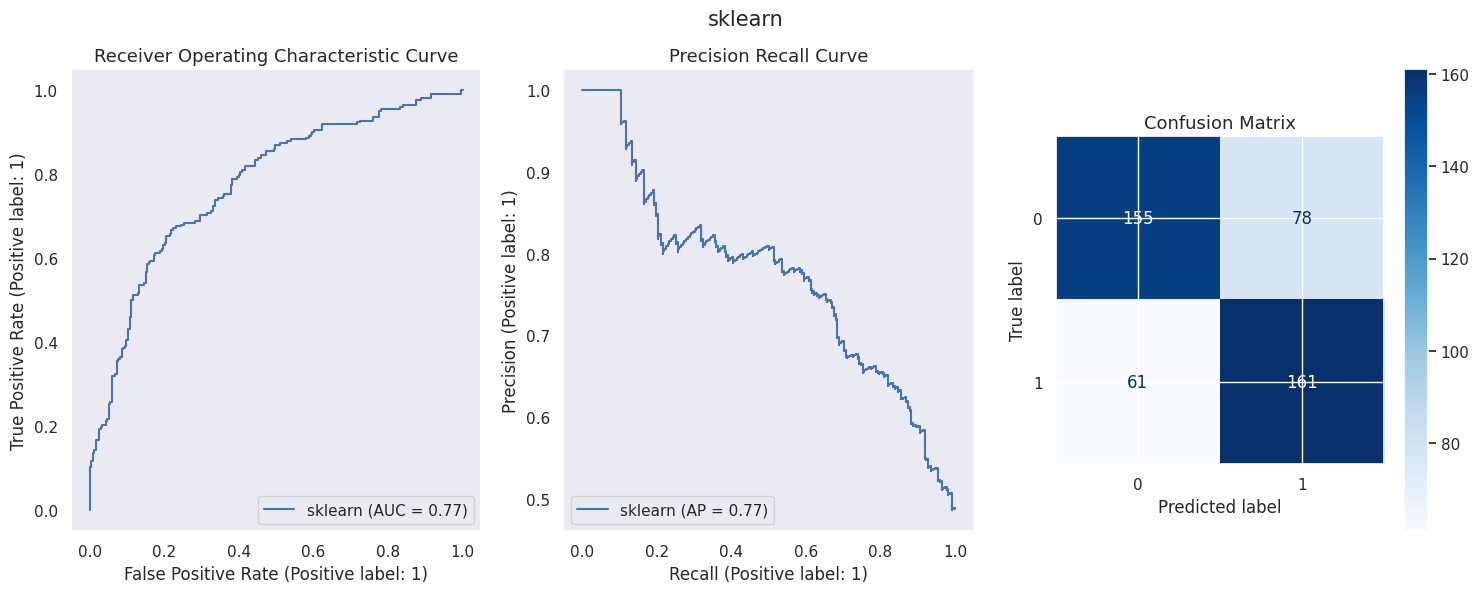

In [185]:
from sklearn.ensemble import VotingClassifier
import itertools

class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[self.cols].copy()

    def fit(self, X, y=None):
        return self


class DFtoList(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def transform(self, X):
        return [' '.join(tweet) for tweet in X.iloc[:,0].tolist()]

    def fit(self, X, y=None):
        return self


class TreatSubject(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def transform(self, X):
        X = X.copy()
        X.subject = np.where(X.subject=='lula', 1, 0)
        return X

    def fit(self, X, y=None):
        return self



X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df.target, test_size=0.20, random_state=SEED)


# Text classifier pipeline
column_extractor_text = ColumnExtractor(['tokens'])
df_to_list = DFtoList()
vec = CountVectorizer()
text_cls = MultinomialNB()

text_cls_pipe = Pipeline(
    steps=[
    ('column_extractor', column_extractor_text),
    ('df_to_list', df_to_list),
    ('vectorizer', vec),
    ('text_cls', text_cls),
    
    ])



# Meta data classifier pipeline
cols_list = ['subject','followers_count', 'following_count', 'listed_count', 'tweet_count', 'nwords', 'avg_word_lenght', 'question_mark_count', 'exclamation_mark_count', 'hashtag_count', 'lexicon']

column_extractor_metadata = ColumnExtractor(cols_list)
treat_subject = TreatSubject()
scaler = MinMaxScaler(clip = True)
metadata_cls = XGBClassifier(random_state=SEED, n_jobs=-1)

metadata_cls_pipe = Pipeline(
    steps=[
    ('column_extractor', column_extractor_metadata),
    ('treat_subject', treat_subject),
    ('scaler', scaler),
    ('metadata_cls', metadata_cls),   
    ])

voting_cls = VotingClassifier(estimators=[('text_cls_pipe', text_cls_pipe), ('metadata_cls_pipe', metadata_cls_pipe)], voting='soft', weights= [1, 1]).fit(X_train, y_train)



params = {
    'text_cls_pipe__vectorizer__ngram_range' : [(1,3)],
    'text_cls_pipe__text_cls__alpha' : [0.7],
    
    'metadata_cls_pipe__metadata_cls__eta': [0.6],
    'metadata_cls_pipe__metadata_cls__max_depth': [None],
    'metadata_cls_pipe__metadata_cls__n_estimators' : [1200],

    'weights' : list(itertools.product(range(1,10), repeat=2))
}



voting_gs = GridSearchCV(voting_cls, params, scoring = metric_score, cv=5, verbose=3).fit(X_train, y_train)
csl_results(voting_gs, X_test, y_test, estimator_name, mlflow_logs = False)

In [151]:


itertools.product(range(1,5), repeat=2)
# list(itertools.product(range(1,5), repeat=2))

In [89]:
df.tokens = [list(tweet) for tweet in df.tokens.tolist()]

In [ ]:
ColumnExtractor('tokens')
vec = CountVectorizer()

2022/08/08 11:30:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e02cf24c07d74701a850ef2a6be77aae', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/08/08 11:31:07 WARNING mlflow.sklearn: Failed to infer model signature: Expected one of (pandas.DataFrame, numpy array, dictionary of (name -> numpy.ndarray), pyspark.sql.DataFrame) but got '<class 'list'>'
2022/08/08 11:31:10 INFO mlflow.sklearn.utils: Logging the 5 best runs, 37 runs will be omitted.





Model: NAIVE BAYESMULTINOMIALNB'>
Best params:
{'estimator__alpha': 0.9, 'vectorizer__ngram_range': (1, 3)}
Best score on train (f1-macro): 0.681

Summary on train
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       960
           1       0.99      0.99      0.99       970

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930


Summary on test
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       172
           1       0.69      0.70      0.70       169

    accuracy                           0.70       341
   macro avg       0.70      0.70      0.70       341
weighted avg       0.70      0.70      0.70       341



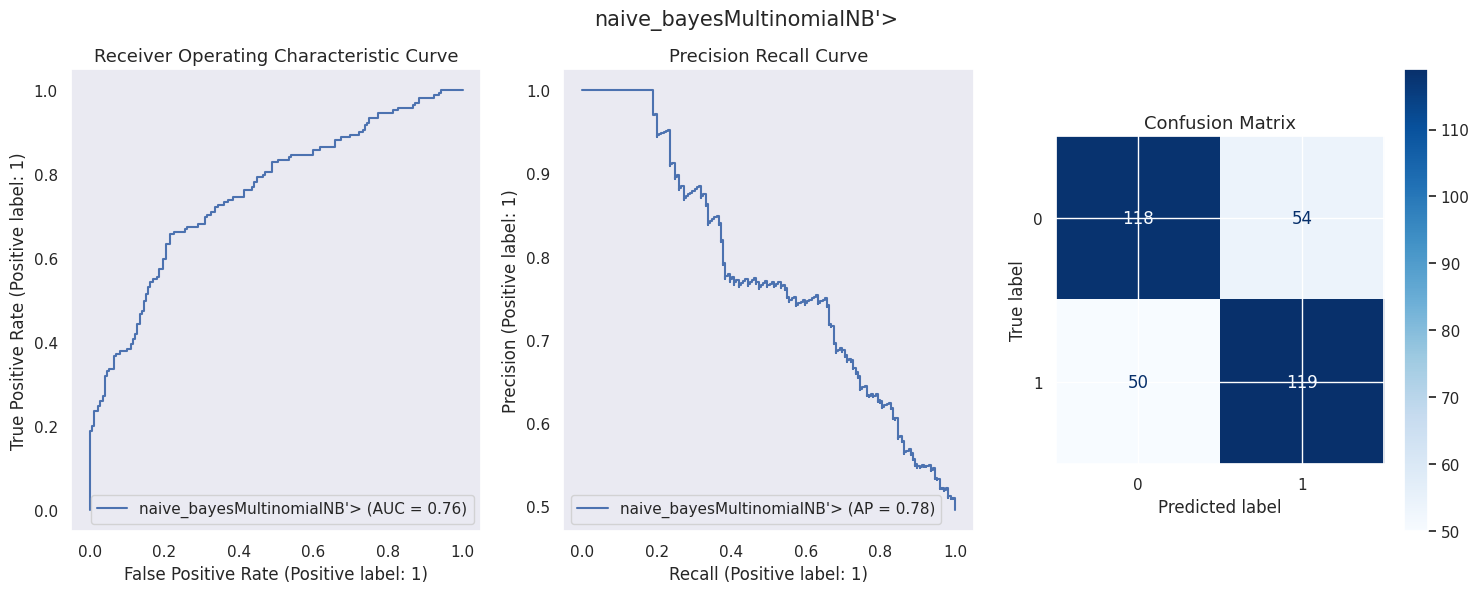

In [21]:
# mlflow.set_experiment("bow_then_meta_data")

# Setup Data
X_train, X_test, y_train, y_test = train_test_split(df.tokens, df.target, test_size=0.15, random_state=SEED)

X_train = [' '.join(tweet) for tweet in X_train.values]
X_test = [' '.join(tweet) for tweet in X_test.values]
y_train = y_train.values
y_test = y_test.values

metric_score = 'accuracy'



metric_score = 'accuracy'

models_dict = {
        MultinomialNB() : {
            'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
            'estimator__alpha' : [0.4,0.5,0.6,0.7,0.8,0.9,1]
        },
        
}

vec = CountVectorizer()
scaler = MinMaxScaler(clip = True)

# union = ColumnTransformer([("vectorizer", vec, 'tokens'), ("scaler", scaler, slice(0,9))])





bow_model = +

estimator_name = str(estimator.__class__).split('.')[1] + str(estimator.__class__).split('.')[2]



pipe = Pipeline(steps=[('vectorizer', vec),('estimator', estimator)])

# Run Grid Search
bow_model = GridSearchCV(pipe, params, scoring = metric_score, cv=10).fit(X_train, y_train)

# Evaluation
csl_results(bow_model, X_test, y_test, estimator_name, mlflow_logs = False)



from sklearn.ensemble import VotingClassifier

esemble = VotingClassifier(n_jobs = -1)


In [ ]:
bow_model

In [ ]:
test_set = pd.concat([X_test_raw,y_test_raw], axis=1)
test_set['predicted'] = gs.predict(X_test)
test_set['prob_pos'] = gs.predict_proba(X_test)[:,1]
test_set = test_set[['subject','text', 'tokens', 'target',	'predicted',	'prob_pos']]
test_set[test_set.target != test_set.predicted].sort_values(['subject','prob_pos']).head(80)

,subject,text,tokens,target,predicted,prob_pos
388,bolsonaro,"Ciro Gomes se defendeu de críticas sobre sua ausência no segundo turno das eleições de 2018, que deu a vitória a Bolsonaro. 💬 ""Eu sou obrigado a andar com ladrão? O Lula agarrado com Renan Calheiros. Pelo amor de Deus, eu tenho vergonha na cara”, disse. https://t.co/hDyqQ2O4KD https://t.co/EvqNpvbFkq","[ciro, gomes, defender, crítica, sobre, ausência, segundo, turno, eleição, 2018, vitória, bolsonaro, obrigar, andar, ladrão, lula, agarrar, renan, calheiros, amor, deus, vergonha, cara]",1,0,0.113374
2047,bolsonaro,@brasuca2099 @gogas93 Amigo do meu amigo é meu amigo. Amigo do meu inimigo é meu inimigo. Parabéns #Bolsonaro.,"[amigo, amigo, amigo, amigo, inimigo, inimigo, parabéns, bolsonaro]",1,0,0.127613
879,bolsonaro,"@wishlickpie @AguiarAnadir @EdRaposo_ Vamos votar sim no Bolsonaro, vc pode ficar em casa naobprecisa votar no Lula não","[votar, sim, bolsonaro, poder, ficar, casa, naobprecisa, votar, lula]",1,0,0.185461
792,bolsonaro,😂😂😂😂😂 ... PGR pede arquivamento de pedido para investigar motociata de Bolsonaro nos EUA ☛ https://t.co/L25pcyAkut,"[frisar, risada, frisar, par, pedir, arquivamento, pedir, investigar, motorista, bolsonaro, eua]",1,0,0.200167
81,bolsonaro,"BOLSONARO JOGA A VERDADE NA CARA DE LULA ""Eu vetei O ORCAMENTO SECRETO A derrubada do veto foi quase unanimidade e o PT votou para derrubar o veto. Agora, o cara do PT diz que é a maior bandidagem dos últimos 200 anos”. ￼ ￼","[bolsonaro, joga, verdade, cara, lula, vetei, orçamento, secreto, derrubar, veto, quase, unanimidade, votar, derrubar, veto, cara, grande, bandidagem, último, 200, ano]",1,0,0.203943
1226,bolsonaro,Falta deixa de ter pensamento e amigos comunistas. Amigos socialistas. Amiguinhos da corrupção. 2018 a luta era contra corrupção e implementação do Comunismo. Hoje se alia as duas coisas. E aí te pergunto: qual a diferença Lula para Bolsonaro se os dois são amigos do Datena? https://t.co/lkawfjooO2,"[falta, deixar, pensamento, amigo, comunista, amigos, socialista, amiguinhos, corrupção, 2018, luta, contra, corrupção, implementação, comunismo, hoje, aliar, dois, coisa, perguntar, diferença, lula, bolsonaro, dois, amigo, faustão]",1,0,0.204199
2075,bolsonaro,"@BlogdoNoblat Se Bolsonaro foi denunciado, certos Ministros do Supremo deveriam o quê? Ser denunciados ou presos???","[blogdonoblat, bolsonaro, denunciar, certos, ministros, supremo, dever, quê, denunciar, prender]",1,0,0.228647
684,bolsonaro,quando eu vejo esses prints de posts do Bolsonaro eu entro no perfil p saber se é real pq pqp não é possivel https://t.co/OiwaM9IMHn,"[vejo, fotos, posts, bolsonaro, entro, perfil, saber, real, puta, pariu, possível]",1,0,0.232299
529,bolsonaro,"Eu esqueço real que o Bolsonaro trocou de partido e que o número dele não é 17, quando lembro, torço pra uma galera esquecer tb, mas daí tb se acontecer isso vão dizer que foi fraude eleitoral então assim","[esqueço, real, bolsonaro, trocar, partir, número, 17, lembro, torço, galera, esquecer, acontecer, fraude, eleitoral, assim]",1,0,0.232645
1174,bolsonaro,"O vaientraube se queima a cada post que faz aqui no Twitter kkkkkkkk quando é com ele, AIN tô sendo perseguido, quando é com os outros, prendam, ele é culpado e Bolsonaro é centrão. Um louco que não fez nada quando era ministro da educação. ABE IS OUT.","[vaientraube, queima, cada, post, aqui, twitter, risada, perseguir, prenda, culpar, bolsonaro, centra, louco, ministro, educação, abe, are, out]",1,0,0.247239


# LDA

In [332]:

# import logging
# logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def tokens_to_tweet(tokens):
    return [' '.join(i) for i in tokens]




def train_lda_model(tweets, num_topics):
    bigram = gensim.models.Phrases(tweets, min_count = 15)

    bigram_mod = gensim.models.phrases.Phraser(bigram)

    bigram = [bigram_mod[tweet] for tweet in df.tokens.tolist()]

    id2word = corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]



    lda_model = models.ldamulticore.LdaMulticore(
                                            corpus=corpus,
                                            num_topics=num_topics,
                                            id2word=id2word,
                                            chunksize=100,
                                            workers=8,
                                            passes=50,
                                            eval_every = 1,
                                            per_word_topics=True
                                        )       
    return lda_model, corpus



def get_lda_vectors(model, corpus, num_topics):
    '''
    Returns vetors for documents
    '''
    train_vecs = []
    for doc in corpus:
        top_topics = model.get_document_topics(doc, minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(num_topics)]
        train_vecs.append(topic_vec)
    return train_vecs




In [358]:
bigram = gensim.models.Phrases(X_train, min_count = 15)

bigram_mod = gensim.models.phrases.Phraser(bigram)

bigram = [bigram_mod[tweet] for tweet in df.tokens.tolist()]

id2word = corpora.Dictionary(bigram)
id2word.filter_extremes(no_below=10, no_above=0.35)
id2word.compactify()
corpus = [id2word.doc2bow(text) for text in bigram]


# bigram

In [341]:

class LDAVectorizer(BaseEstimator,TransformerMixin):
    def __init__(self, num_topics=20):
        self.num_topics = num_topics


    def _pre_transform(self, X):

        # Build bigrams
        bigram = gensim.models.Phrases(X, min_count = 15)
        bigram_mod = gensim.models.phrases.Phraser(bigram)
        bigram = [bigram_mod[tweet] for tweet in df.tokens.tolist()]

        # Build id2word
        id2word = corpora.Dictionary(bigram)
        id2word.filter_extremes(no_below=10, no_above=0.35)
        id2word.compactify()
        corpus = [id2word.doc2bow(text) for text in bigram]

        return corpus, id2word


    def fit(self,X,y=None):
        '''
        X must be a list of docs, where a doc is a list of tokens.
        '''
        corpus, id2word =  self._pre_transform(X)

        self.model = models.ldamulticore.LdaMulticore(
                                                corpus=corpus,
                                                num_topics=num_topics,
                                                id2word=id2word,
                                                chunksize=100,
                                                workers=8,
                                                passes=50,
                                                eval_every = 1,
                                                per_word_topics=True
                                            )       
        return self
    

    def transform(self,X,y=None):
        '''
        Returns vetors for documents
        '''
        corpus, _ = self._pre_transform(X)
        train_vecs = []
        for doc in corpus:
            top_topics = self.model.get_document_topics(doc, minimum_probability=0.0)
            topic_vec = [top_topics[i][1] for i in range(self.num_topics)]
            train_vecs.append(topic_vec)

        return np.array(train_vecs)


In [383]:
from sklearn.decomposition import LatentDirichletAllocation



# [np.array(i) for i in X_train.values][0]
# CountVectorizer().fit_transform([' '.join(tweet) for tweet in X_train.values])
# [' '.join(tweet) for tweet in X_train.values]

2022/08/08 21:48:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '338adcb6dedd498ea41deda411a8f5a4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/08/08 21:48:55 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/08/08 21:48:55 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature


LatentDirichletAllocation()

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END estimator__alpha=0.4, vec_bow__ngram_range=(1, 3), vec_lda__n_components=5;, score=0.492 total time=   2.1s
[CV 2/5] END estimator__alpha=0.4, vec_bow__ngram_range=(1, 3), vec_lda__n_components=5;, score=0.544 total time=   2.1s
[CV 3/5] END estimator__alpha=0.4, vec_bow__ngram_range=(1, 3), vec_lda__n_components=5;, score=0.497 total time=   2.2s
[CV 4/5] END estimator__alpha=0.4, vec_bow__ngram_range=(1, 3), vec_lda__n_components=5;, score=0.492 total time=   2.1s
[CV 5/5] END estimator__alpha=0.4, vec_bow__ngram_range=(1, 3), vec_lda__n_components=5;, score=0.466 total time=   2.0s
[CV 1/5] END estimator__alpha=0.4, vec_bow__ngram_range=(1, 3), vec_lda__n_components=15;, score=0.531 total time=   2.1s
[CV 2/5] END estimator__alpha=0.4, vec_bow__ngram_range=(1, 3), vec_lda__n_components=15;, score=0.518 total time=   2.1s
[CV 3/5] END estimator__alpha=0.4, vec_bow__ngram_range=(1, 3), vec_lda__n_components=15;

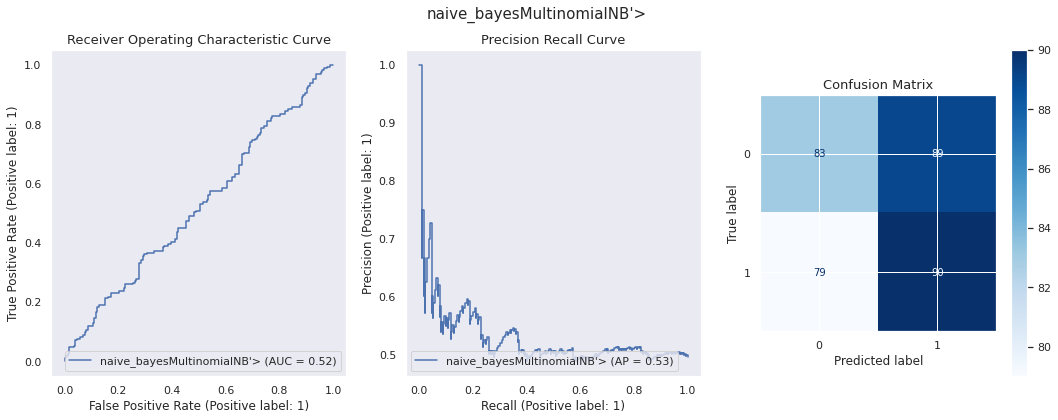

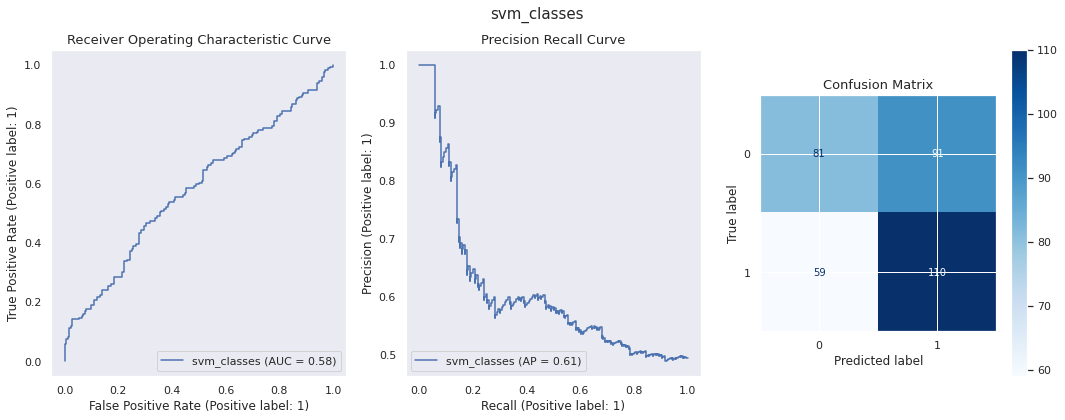

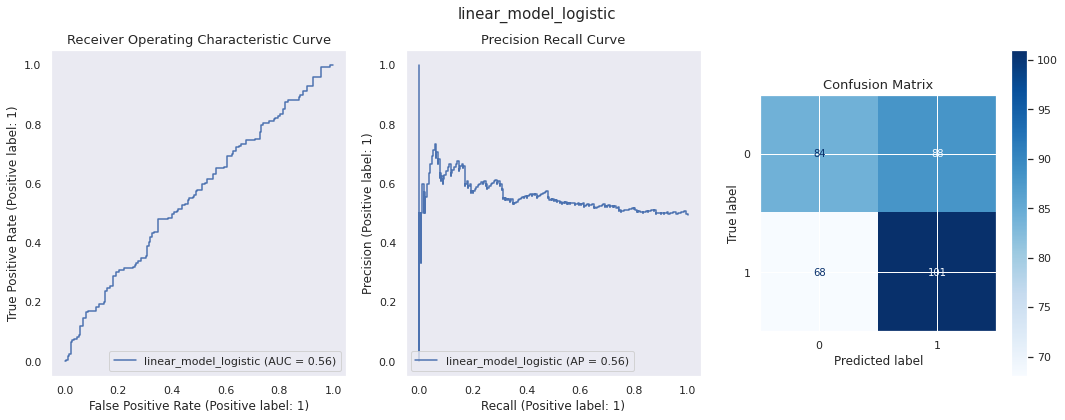

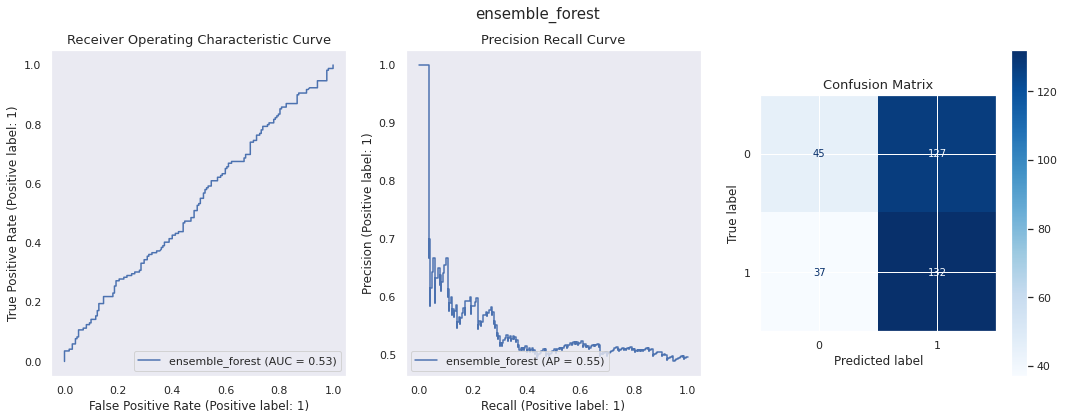

In [13]:
from sklearn.decomposition import LatentDirichletAllocation
# mlflow.set_experiment("lda")


# Setup Data
X_train, X_test, y_train, y_test = train_test_split(df.tokens, df.target, test_size=0.15, random_state=SEED)

X_train = [' '.join(tweet) for tweet in X_train.values]
X_test = [' '.join(tweet) for tweet in X_test.values]
y_train = y_train.values
y_test = y_test.values

metric_score = 'accuracy'

# (1,1),(1,2),(2,2),(2,3),(3,3),(

models_dict = {
        MultinomialNB() : {
            'vec_bow__ngram_range' : [(1,3)],
            # 'vec_bow__max_df' : [0,5],
            # 'vec_bow__min_df' : [0,5,10],
            'vec_lda__n_components' : [5,15,20,25,30],
            'estimator__alpha' : [0.4,0.5,0.6,0.7,0.8,0.9,1]
        },
        
        LinearSVC(random_state=SEED) : {
            'vec_bow__ngram_range' : [(1,3)],
            # 'vec_bow__max_df' : [0,5],
            # 'vec_bow__min_df' : [0,5,10],
            'vec_lda__n_components' : [5,15,20,25,30],
            'estimator__loss': ['hinge', 'squared_hinge'], 
            'estimator__penalty': ['l1', 'l2'],
            'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        },
        LogisticRegression(n_jobs = -1, random_state=SEED) : {
            'vec_bow__ngram_range' : [(1,3)],
            # 'vec_bow__max_df' : [0,5],
            # 'vec_bow__min_df' : [0,5,10],
            'vec_lda__n_components' : [5,15,20,25,30],
            'estimator__penalty': ['l1', 'l2', 'elasticnet'],
            'estimator__dual': [True],
            'estimator__solver' : ['liblinear'],
            'estimator__C': [0.001,0.1,0.5,1,3,5,8,10], 
        },
        # DecisionTreeClassifier(random_state=SEED) : {
        #     'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
        #     'estimator__min_samples_split': [2,3,5,8,13,21,34],
        #     'estimator__max_features': ['autp', 'log2'],
        # },
        # KNeighborsClassifier(n_jobs = -1) : {
        #     'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
        #     'estimator__n_neighbors': [2,3,5,8,13,21,34],
        #     'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        # },
         RandomForestClassifier(random_state=SEED, n_jobs=-1) : {
          'vec_bow__ngram_range' : [(1,3)],
            # 'vec_bow__max_df' : [0,5],
            # 'vec_bow__min_df' : [0,5,10],
          'vec_lda__n_components' : [5,15,20,25,30],
          'estimator__min_samples_split': [6],
          'estimator__min_samples_leaf': [6],
          'estimator__max_depth': [None],
          'estimator__n_estimators' : [800]
        },
        #  XGBClassifier(random_state=SEED, n_jobs=-1) : {
        #   'vectorizer__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)],
        #   'estimator__max_depth': [2,3,5,8],
        #   'estimator__eta': [0.05,0.1,0.3,0.5],
        #   'estimator__max_depth': [None],
        #   'estimator__n_estimators' : [200]
        # },


}


vec_bow = CountVectorizer()
vec_lda = LatentDirichletAllocation()

for estimator,params in models_dict.items():
    
    estimator_name = str(estimator.__class__).split('.')[1] + str(estimator.__class__).split('.')[2]
    
    # with mlflow.start_run():
    #     mlflow.set_tag('model', estimator_name)
    #     mlflow.sklearn.autolog()
# Create pipeline
    steps = [('vec_bow', vec_bow),('vec_lda', vec_lda),('estimator', estimator)]
    pipe = Pipeline(steps=steps)

    # Run Grid Search
    gs = GridSearchCV(pipe, params, scoring = metric_score, cv=5,verbose=3).fit(X_train, y_train)

    # Evaluation
    csl_results(gs, X_test, y_test, estimator_name, mlflow_logs=False)

In [393]:
mlflow.autolog(disable=True)

In [343]:
corpus = LDAVectorizer().fit_transform(X_train)

In [345]:
corpus.shape

(2271, 20)

In [347]:
len(X_train)

1930

In [335]:
num_topics = 20
tweets = df.tokens.tolist()




lda_model, corpus = train_lda_model(tweets, num_topics)


lda_vec = get_lda_vectors(lda_model, corpus, num_topics)


for i, words in enumerate(lda_model.print_topics()):
    words = re.findall('[a-zÀ-ÿ]+',words[1])
    print('\n',i, ': ',words)


 0 :  ['brasileiro', 'ninguém', 'alckmin', 'governo', 'governar', 'política', 'achar', 'mão', 'paulo', 'mil']

 1 :  ['crime', 'veja', 'casa', 'matar', 'jair', 'apoiador', 'igual', 'ódio', 'escolher', 'ladrão']

 2 :  ['anitta', 'achar', 'apoio', 'sobre', 'candidato', 'chamar', 'rede', 'político', 'petista', 'respeito']

 3 :  ['governo', 'político', 'lulaoficial', 'vez', 'eleger', 'caso', 'deputado', 'senador', 'público', 'onde']

 4 :  ['lei', 'amigo', 'terceiro', 'turno', 'esquecer', 'haddad']

 5 :  ['gente', 'frisar', 'esquerda', 'cara', 'seguir', 'lá', 'frisar', 'risada', 'medo', 'assim', 'votar']

 6 :  ['sempre', 'família', 'verdade', 'deus', 'suplicy', 'nome', 'governo', 'tudo', 'vida', 'além']

 7 :  ['brasil', 'dia', 'bom', 'lulaoficial', 'reeleger', 'voltar', 'hora', 'ajudar', 'presidente']

 8 :  ['brasil', 'brasil', 'ganhar', 'prender', 'golpe', 'vencer', 'aplauso', 'colocar', 'eleitor', 'certeza']

 9 :  ['defender', 'força', 'liberdade', 'senhor', 'defesa', 'governo', 

In [334]:
len(lda_vec)

2271

In [220]:
import gensim
import gensim.corpora as corpora
from gensim import models



dictionary = corpora.Dictionary(df.tokens.tolist())
corpus = [dictionary.doc2bow(tweet) for tweet in df.tokens.tolist()]

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]


lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=20)

In [227]:
df.tokens.tolist()[4]

['bolsonaro',
 'sancionar',
 'lei',
 'devolver',
 'abono',
 'tributários',
 'cobrar',
 'contar',
 'luz']

In [226]:
lda_model[corpus[4]]

[(12, 0.90500003)]

In [228]:
lda_model.get_document_topics(corpus[4])

[(12, 0.90500003)]

In [232]:
import re
re.findall('[a-z]+','0.039*"lula" + 0.022*"bolsonaro" + 0.010*"brasil" + 0.008*"presidente" + 0.007*"governo" + 0.007*"apoio" + 0.006*"votar" + 0.006*"esquerda" + 0.004*"cara" + 0.004*"algum"')

['lula',
 'bolsonaro',
 'brasil',
 'presidente',
 'governo',
 'apoio',
 'votar',
 'esquerda',
 'cara',
 'algum']

In [243]:
words[1]

'0.065*"lula" + 0.038*"brasil" + 0.032*"bolsonaro" + 0.016*"presidente" + 0.006*"povo" + 0.006*"país" + 0.005*"governo" + 0.005*"bom" + 0.005*"ano" + 0.004*"lulaoficial"'

In [244]:
bag = []
for i, words in enumerate(lda_model.print_topics()):
    words = re.findall('[a-zÀ-ÿ]+',words[1])
    print('\n',i, ': ',words)
    bag += words


 0 :  ['lula', 'bolsonaro', 'presidente', 'risada', 'votar', 'contra', 'ciro', 'esquerda', 'voto', 'primeiro']

 1 :  ['lula', 'bolsonaro', 'presidente', 'poder', 'brasil', 'governo', 'povo', 'bom', 'passar', 'primeiro']

 2 :  ['lula', 'bolsonaro', 'brasil', 'contra', 'votar', 'presidente', 'turno', 'governo', 'tentar', 'ciro']

 3 :  ['lula', 'bolsonaro', 'povo', 'presidente', 'olé', 'votar', 'brasil', 'gente', 'brasileiro', 'conseguir']

 4 :  ['lula', 'bolsonaro', 'brasil', 'presidente', 'corrupção', 'tudo', 'pessoa', 'ficar', 'ganhar', 'risada']

 5 :  ['bolsonaro', 'lula', 'presidente', 'governo', 'primeiro', 'coisa', 'corrupção', 'dinheiro', 'cara', 'país']

 6 :  ['bolsonaro', 'lula', 'governo', 'país', 'primeiro', 'brasil', 'turno', 'corrupto', 'nome', 'lulaoficial']

 7 :  ['bolsonaro', 'lula', 'brasil', 'governo', 'ano', 'poder', 'dinheiro', 'mandar', 'ministro', 'presidente']

 8 :  ['lula', 'bolsonaro', 'votar', 'crime', 'frisar', 'lulaoficial', 'jairbolsonaro', 'governo'

In [247]:
from collections import Counter

counter = Counter(bag)

counter.most_common(40)



[('lula', 20),
 ('bolsonaro', 20),
 ('presidente', 16),
 ('brasil', 16),
 ('risada', 8),
 ('votar', 8),
 ('governo', 8),
 ('poder', 6),
 ('turno', 6),
 ('povo', 5),
 ('lulaoficial', 5),
 ('primeiro', 4),
 ('país', 4),
 ('frisar', 4),
 ('contra', 3),
 ('ciro', 3),
 ('bom', 3),
 ('pessoa', 3),
 ('dinheiro', 3),
 ('anitta', 3),
 ('esquerda', 2),
 ('voto', 2),
 ('gente', 2),
 ('corrupção', 2),
 ('tudo', 2),
 ('ficar', 2),
 ('coisa', 2),
 ('cara', 2),
 ('ano', 2),
 ('crime', 2),
 ('ladrão', 2),
 ('passar', 1),
 ('tentar', 1),
 ('olé', 1),
 ('brasileiro', 1),
 ('conseguir', 1),
 ('ganhar', 1),
 ('corrupto', 1),
 ('nome', 1),
 ('mandar', 1)]

In [216]:
for c, x, v in lda_model[corpus[5:8]]:
    print("Document Topics      : ", c[0])      # [(Topics, Perc Contrib)]
    print("Word id, Topics      : ", c[1][:3])  # [(Word id, [Topics])]
    print("Phi Values (word id) : ", c[2][:2])  # [(Word id, [(Topic, Phi Value)])]
    print("Word, Topics         : ", [(dct[wd], topic) for wd, topic in c[1][:2]])   # [(Word, [Topics])]
    print("Phi Values (word)    : ", [(dct[wd], topic) for wd, topic in c[2][:2]])  # [(Word, [(Topic, Phi Value)])]
    print("------------------------------------------------------\n")

ValueError: too many values to unpack (expected 2)

In [ ]:
TruncatedSVD